In [1]:
import pyparax as parax
import numpy as np 
import pandas as pd
import scipy as sp
from math import pi
import matplotlib.pyplot as plt

In [ ]:
E_field_lst = np.loadtxt('E_lst.csv', delimiter=',',dtype=complex)
X_lst = pd.read_csv('total_clean_data_1.csv')

In [5]:
lambda_=1.3e-10
window_extent = 3e-4
grid_dim = 64
upsize_dim = 550

def phi(X, b, a):
    #return a + pi*(X[0]**2+X[1]**2)/(lambda_*R)
    return a + b*(X[0]**2+X[1]**2)

In [ ]:
def curvature_radius_phi(E):
    E_abs = np.abs(E)
    pmf = E_abs/np.sum(E_abs)
    l = np.linspace(-window_extent/2,window_extent/2,grid_dim)
    marg_x = np.sum(pmf,axis=0)
    marg_y = np.sum(pmf,axis=1)
    E_x = np.sum(marg_x*l)
    E_y = np.sum(marg_y*l)
    var_x = np.sum((marg_x - E_x)**2)
    var_y = np.sum((marg_y - E_y)**2)
    cov = np.sum(pmf*(l.reshape(grid_dim,1)@l.reshape(1,grid_dim))) - E_x*E_y
    w = np.sqrt(var_x*var_y - cov**2)
    x_mesh, y_mesh  = np.meshgrid(l-E_x,l-E_y)
    X = np.vstack((x_mesh.flatten(),y_mesh.flatten()))
    #plt.imshow(x_mesh*y_mesh)
    #phi = lambda X, R, a: a - np.arctan(pi*w**2/(R*lambda_))+ pi*(X[0]**2+X[1]**2)/(lambda_*R)
    parameters, pcov = sp.optimize.curve_fit(phi,X,np.angle(E).flatten())
    R_i = parameters[0]
    return np.array([R_i, np.sqrt(pcov[0,0])])

In [57]:
N = 21
curvature_radius(E_field_lst[N].reshape((64,64)))
plt.imshow(np.angle(E_field_lst[N].reshape((64,64))))

NameError: name 'curvature_radius' is not defined

In [60]:
np.savetxt('E_21.csv',E_field_lst[N].reshape((64,64)),delimiter=',')

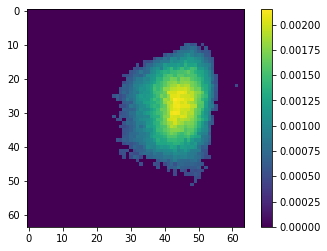

In [58]:
plt.imshow(np.abs(E_field_lst[N].reshape((grid_dim,grid_dim))))
plt.colorbar()

In [206]:
E_abs = np.abs(E_field_lst[N].reshape((grid_dim,grid_dim)))
pmf = E_abs/np.sum(E_abs)
l = np.linspace(-window_extent/2,window_extent/2,grid_dim)
marg_x = np.sum(pmf,axis=0)
marg_y = np.sum(pmf,axis=1)
E_x = np.sum(marg_x*l)
E_y = np.sum(marg_y*l)
var_x = np.sum((marg_x - E_x)**2)
var_y = np.sum((marg_y - E_y)**2)
cov = np.sum(pmf*(l.reshape(grid_dim,1)@l.reshape(1,grid_dim))) - E_x*E_y
w = np.sqrt(var_x*var_y - cov**2)
x_mesh, y_mesh  = np.meshgrid(l-E_x,l-E_y)
X = np.vstack((x_mesh.flatten(),y_mesh.flatten()))
#plt.imshow(x_mesh*y_mesh)
#phi = lambda X, R, a: a - np.arctan(pi*w**2/(R*lambda_))+ pi*(X[0]**2+X[1]**2)/(lambda_*R)
x0=np.array([.01,1,1,3e-4/64])
y =E_abs.flatten()
#x0=np.ones(2)
pfit, pcov, infodict, errmsg, success = leastsq(residuals,x0, args=(X,y),full_output=1)

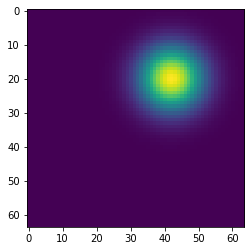

In [254]:
func = np.abs(gauss_beam(X,pfit[0],pfit[1],pfit[2],pfit[3]).reshape((grid_dim,grid_dim)))
plt.imshow(func)
#plt.ylim(np.min(func),np.max(func))

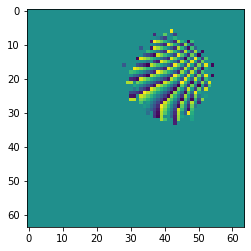

In [209]:
plt.imshow(np.angle(E_field_lst[N].reshape((grid_dim,grid_dim))))

In [ ]:
#parax.numeric_parameters.N_x = grid_dim
#parax.numeric_parameters.N_y = grid_dim
#parax.numeric_parameters.dx = 1000*window_extent/grid_dim
#parax.numeric_parameters.dy = 1000*window_extent/grid_dim
parax.numeric_parameters.x0 = E_x
parax.numeric_parameters.y0 = E_y
parax.numeric_parameters.wavelength = 1.3e-10
parax.numeric_parameters.dx=0.01
parax.numeric_parameters.dy=0.01
parax.numeric_parameters.dz=0.01

In [ ]:
for E_field in E_field_lst:
    E_field = E_field.reshape((grid_dim,grid_dim))
    system = [10]
    f = parax.experimental_simulator.experimental_simulator_2d.propagate(f0, system, output_full = True, forward = False, print_output=True)

In [ ]:
R_z = []
for field_slice in f[:50]:
    R_z.append(curvature_radius(field_slice))

In [ ]:
f0 = E_field_lst[N].reshape(grid_dim,grid_dim)
system = [100]
f = parax.experimental_simulator.experimental_simulator_2d.propagate(f0, system, output_full = True, forward = False, print_output=True)
#parax.experimental_simulator.plotters.full_beam_plot_2d(fwindow_extent, system, forward = False, which = 'abs')

In [ ]:
parax.numeric_parameters.N_x?

In [ ]:
np.abs(f0)[:42,22:].shape

In [ ]:
plt.imshow(np.angle(f[0]))

In [ ]:
R_z = np.zeros((f.shape[0],2))
for i,field_slice in enumerate(f):
    R_z[i] = curvature_radius(field_slice)

In [ ]:
R_z[10:20]

In [ ]:
plt.plot(pi/(lambda_*R_z[:,0]))
#plt.ylim(0,1e10)

In [ ]:
plt.errorbar(x=np.arange(len(R_z)),y=R_z[:,0],yerr=R_z[:,1],marker='o',linestyle='-', alpha = 0.5)

Test it on a regular gaussian beam to get a sense of what the $R(z)$ profile might look like

In [ ]:
parax.numeric_parameters.N_x = grid_dim
parax.numeric_parameters.N_y = grid_dim
parax.numeric_parameters.dz = 1

g0 = parax.function_generator.standard_initial_conditions.generate_gauss_2d(0,0,0.1,0.1)
system = [1000]
g = parax.experimental_simulator.experimental_simulator_2d.propagate(g0, system, output_full = True, forward = False, print_output=True)


In [ ]:
plt.imshow(np.abs(g[0]))

In [ ]:
R_z

In [ ]:
R_z = np.zeros((g.shape[0]-1,2))
for i,field_slice in enumerate(g[1:]):
    R_z[i] = curvature_radius(field_slice)

In [ ]:
plt.errorbar(x=np.arange(1000),y=R_z[:1000,0],yerr=R_z[:1000,1],marker='o',linestyle='-', alpha = 0.5)

In [ ]:
L = np.arange(10)
plt.plot(L*(1 + (150/L)**2))
#plt.plot(1/(L*(1 + (150/L)**2)))

In [ ]:
sp.optimize.leastsq?

In [235]:
import cmath
from scipy.optimize import leastsq
def gauss_beam(x,A,a,b,w):
    return A*np.exp(-(x[0]**2+x[1]**2)/w**2) * np.exp(1j*(a + pi*(x[0]**2+x[1]**2)/(b*lambda_)))

def residuals(p,x,y):
    A,a,b,w=p
    #sim=A*np.exp(-(x[0]**2+x[1]**2)/w**2) * np.exp(1j*(a + pi*(x[0]**2+x[1]**2)/(b*lambda_)))
    sim = gauss_beam(x,A,a,b,w)
    diff = y - sim
    return np.abs(diff)
# def residuals(p,x,y,w):
#     a,b = p
#     sim = a + pi*(X[0]**2+X[1]**2)/(lambda_*b)
#     diff = y-sim
#     return diff**2


def curvature_radius_E(E):
    E_abs = np.abs(E)
    pmf = E_abs/np.sum(E_abs)
    l = np.linspace(-window_extent*upsize_dim/(2*grid_dim),window_extent*upsize_dim/(2*grid_dim),upsize_dim)
    marg_x = np.sum(pmf,axis=0)
    marg_y = np.sum(pmf,axis=1)
    E_x = np.sum(marg_x*l)
    E_y = np.sum(marg_y*l)
    var_x = np.sum((marg_x - E_x)**2)
    var_y = np.sum((marg_y - E_y)**2)
    cov = np.sum(pmf*(l.reshape(upsize_dim,1)@l.reshape(1,upsize_dim))) - E_x*E_y
    w = np.sqrt(var_x*var_y - cov**2)
    l_fit = np.linspace(-window_extent/(2),window_extent/(2),grid_dim)
    x_mesh, y_mesh  = np.meshgrid(l_fit-E_x,l_fit-E_y)
    x = np.vstack((x_mesh.flatten(),y_mesh.flatten()))
    grid_spacing = window_extent/grid_dim
    E_x_loc = int(E_x/grid_spacing + upsize_dim/2)
    E_y_loc = int(E_y/grid_spacing + upsize_dim/2)
    y = E_abs[(E_y_loc-32):(E_y_loc+32),(E_x_loc-32):(E_x_loc+32)].flatten()
    #gauss_beam = lambda X,A,a,b: A*np.exp(-(X[0]**2+X[1]**2)/w**2) * np.exp(1j*(a + b*(X[0]**2+X[1]**2)))
    #parameters, pcov = sp.optimize.t(gauss_beam,X,E.flatten())
    x0=np.array([.01,1,1,grid_spacing])
    #y = np.angle(E).flatten()
    #x0=np.ones(2)
    pfit, pcov, infodict, errmsg, success = leastsq(residuals,x0, args=(x,y),full_output=1)
    if (success == 1 or success == 2 or success == 3 or success == 4) and np.all(pcov != None):
        return [pfit, np.diag(pcov), np.sqrt(np.mean(residuals(pfit,x,y))),w,E_x_loc,E_y_loc]
    else:
        return [np.nan*np.ones(4), np.nan*np.ones(4), np.nan,w,E_x_loc,E_y_loc]

In [220]:
parax.numeric_parameters.wavelength = 1.3e-7
parax.numeric_parameters.dx=1000*window_extent/(grid_dim)
parax.numeric_parameters.dy=1000*window_extent/(grid_dim)
parax.numeric_parameters.dz=1000

#parax.numeric_parameters.unit = 1000
#parax.numeric_parameters.wavelength = 1.3e-10
# Number of points on the x and y axes
parax.numeric_parameters.N_x = upsize_dim
parax.numeric_parameters.N_y = upsize_dim
# Spacing of points on the x and y axes
#parax.numeric_parameters.dx=window_extent/(grid_dim)
#parax.numeric_parameters.dy=window_extent/(grid_dim)
#parax.numeric_parameters.dz=1

# parax.numeric_parameters.unit = 1000
# parax.numeric_parameters.wavelength = 1.3e-10
# parax.numeric_parameters.dx=0.00001
# parax.numeric_parameters.dy=0.00001
# parax.numeric_parameters.dz=0.1

In [ ]:
field_center = E_field_lst[N].reshape(grid_dim,grid_dim)

f0 = 1j*np.zeros((upsize_dim,upsize_dim))
f0[(upsize_dim//2-32):(upsize_dim//2+32),(upsize_dim//2-32):(upsize_dim//2+32)] = field_center
system = [80000]
f = parax.experimental_simulator.experimental_simulator_2d.propagate(f0, system, output_full = True, forward = False, print_output=True)

In [ ]:
# center of the transverse intensity dsn in the pixel map
32*(1 + E_y/(1.5e-4)), 32*(1 + E_x/(1.5e-4))

In [ ]:
plt.imshow(np.abs(field_center))

/tmp/ipykernel_40744/1077228862.py:4: UserWarning: No contour levels were found within the data range.
  plt.contour(np.abs(gauss_beam(x,params[1][0],params[1][1],params[1][2],params[1][3]).reshape((upsize_dim,upsize_dim))))


IndexError: index 1 is out of bounds for axis 0 with size 1

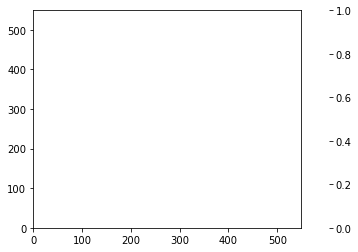

In [238]:
l = np.linspace(-window_extent*upsize_dim/(2*grid_dim),window_extent*upsize_dim/(2*grid_dim),upsize_dim)
x_mesh, y_mesh  = np.meshgrid(l,l)
x = np.vstack((x_mesh.flatten(),y_mesh.flatten()))
plt.contour(np.abs(gauss_beam(x,params[1][0],params[1][1],params[1][2],params[1][3]).reshape((upsize_dim,upsize_dim))))
plt.colorbar()

In [165]:
np.abs(gauss_beam(x,params[1][0],params[1][1],params[1][2],params[1][3]).reshape((upsize_dim,upsize_dim)))[E_y_locs[1],E_x_locs[1]]

0.0

In [182]:
E_x_locs[1],E_y_locs[1]

(286, 263)

In [251]:
k = 10

In [245]:
params[11]

array([[nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       ...,
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, ..., nan+nanj, nan+nanj, nan+nanj]])

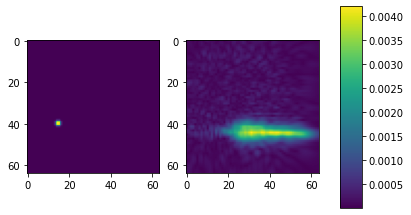

In [252]:
fig, axes = plt.subplots(nrows=1, ncols=2)
for i,ax in enumerate(axes.flat):
    if i ==0:
        im = ax.imshow(np.abs(gauss_beam(x,params[k][0],params[k][1],params[k][2],params[k][3]).reshape((upsize_dim,upsize_dim)))[(E_y_locs[k]-32):(E_y_locs[k]+32),(E_x_locs[k]-32):(E_x_locs[k]+32)])
    else:
        im = ax.imshow(np.abs(f[k][(E_y_locs[k]-32):(E_y_locs[k]+32),(E_x_locs[k]-32):(E_x_locs[k]+32)]))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

In [ ]:
plt.plot(100*np.abs(gauss_beam(x,params[1][0],params[1][1],params[1][2],params[1][3]).reshape((upsize_dim,upsize_dim)))[35])
plt.plot(np.abs(f[1][(E_y_locs[1]-32):(E_y_locs[1]+32),(E_x_locs[1]-32):(E_x_locs[1]+32)])[35])

In [ ]:
np.max(np.abs(gauss_beam(x,params[1][0],params[1][1],params[1][2],params[1][3]).reshape((upsize_dim,upsize_dim))))

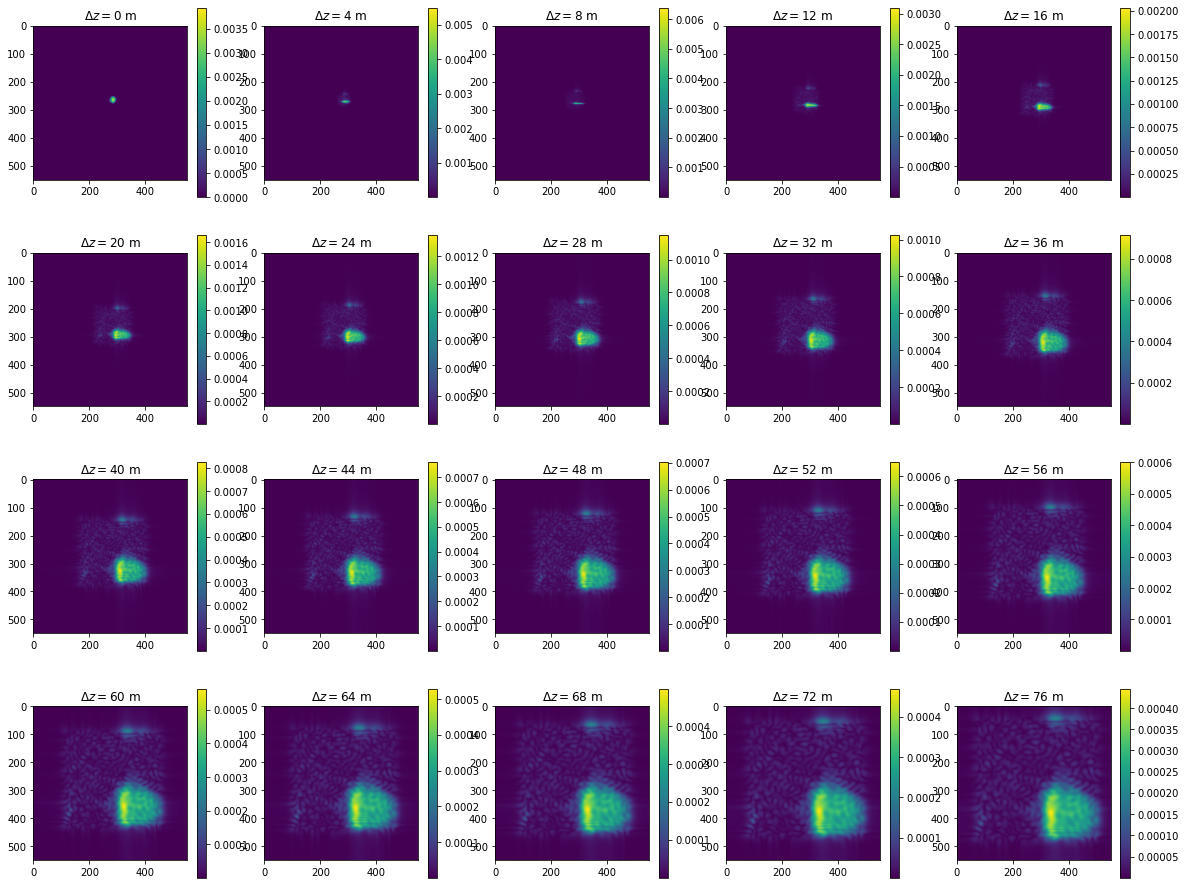

In [236]:
plt.figure(figsize=(20,16))

for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(np.abs(f[i*4]))
    plt.title('$\Delta z = $' + str(i*4) + ' m')
    plt.colorbar()

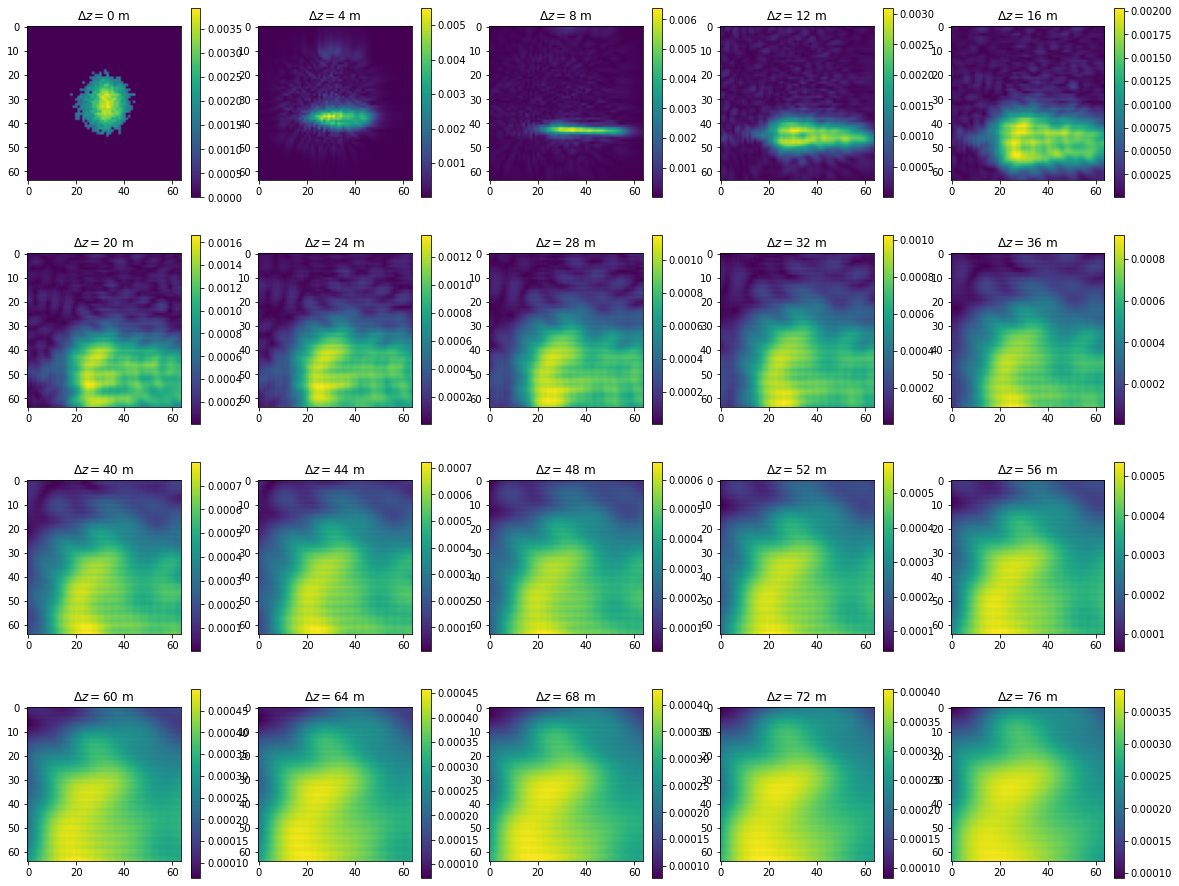

In [163]:

plt.figure(figsize=(20,16))

for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(np.abs(f[i*4][(E_y_locs[i*4]-32):(E_y_locs[i*4]+32),(E_x_locs[i*4]-32):(E_x_locs[i*4]+32)]))
    plt.title('$\Delta z = $' + str(i*4) + ' m')
    plt.colorbar()

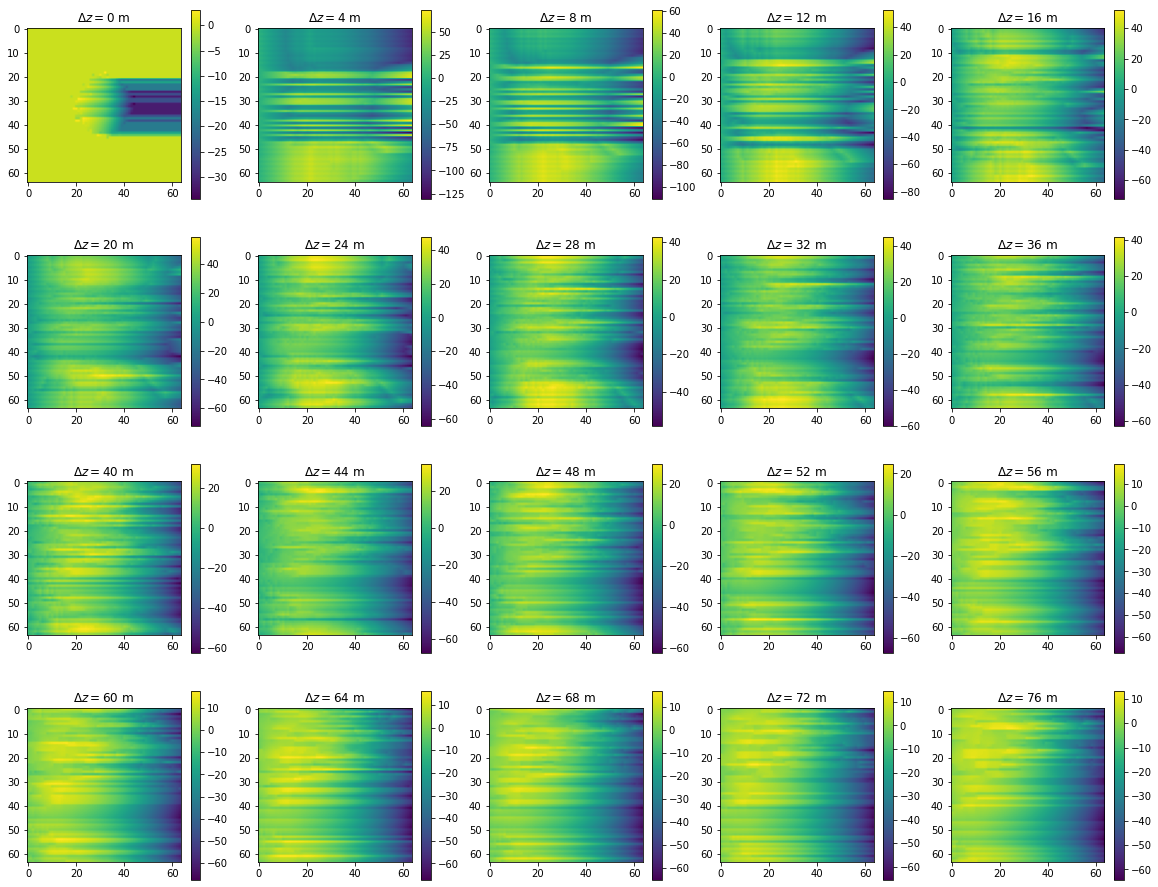

In [167]:

plt.figure(figsize=(20,16))

for i in range(20):
    plt.subplot(4,5,i+1)
    plt.imshow(np.unwrap(np.angle(f[i][(E_y_locs[i]-32):(E_y_locs[i]+32),(E_x_locs[i]-32):(E_x_locs[i]+32)])))
    plt.title('$\Delta z = $' + str(i*4) + ' m')
    plt.colorbar()

In [237]:
w_lst=[]
params = np.zeros((f.shape[0],4))
hess_inv = np.zeros((f.shape[0],4))
err_lst = []
E_x_locs = []
E_y_locs = []

for i,field_slice in enumerate(f):
    params[i], hess_inv[i], err, w_z, E_x, E_y = curvature_radius_E(field_slice)
    w_lst.append(w_z)
    err_lst.append(err)
    E_x_locs.append(E_x)
    E_y_locs.append(E_y)
    #R_z.append(curvature_radius_E(field_slice))

In [169]:
len_nan = sum(np.isnan(params))[0]
params = params[np.logical_not(np.isnan(params))].reshape((params.shape[0] - len_nan,4))
# def for variance of the residual should give us not the sqrt of the function appended, but in fact the square
res = [np.sqrt(hess_inv[i])*err**2 for err in range(len(err_lst)) if np.any(hess_inv[i] == np.nan)]
#hess_inv = hess_inv[np.logical_not(np.isnan(hess_inv))].reshape((hess_inv.shape[0] - len_nan,3))

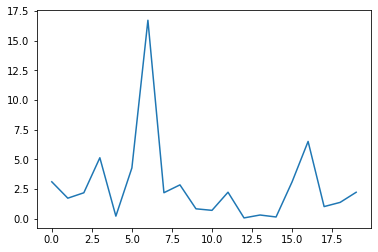

In [170]:
plt.plot(np.arange(len(params)),np.abs(params[:,1]))

In [171]:
plt.errorbar(.1*np.arange(len(params)),np.abs(params[:,1]),yerr=(res[:1994]*np.sqrt(hess_inv[:,1])),marker='.', alpha=0.6)
plt.xlabel('m')
plt.ylabel('$a$')

/tmp/ipykernel_40744/2105942996.py:1: RuntimeWarning: invalid value encountered in sqrt
  plt.errorbar(.1*np.arange(len(params)),np.abs(params[:,1]),yerr=(res[:1994]*np.sqrt(hess_inv[:,1])),marker='.', alpha=0.6)


ValueError: operands could not be broadcast together with shapes (0,) (81,) 

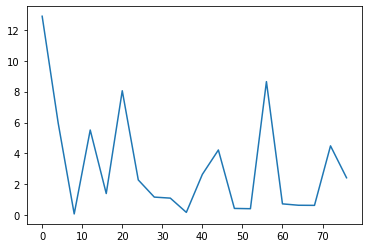

In [172]:
plt.plot(4*np.arange(len(params)),np.abs(params[:,2]))

In [173]:
param_se = [err_lst[i]*np.sqrt(hess_inv[i][0]) for i in range(len(err_lst)) if hess_inv[i][0] != np.nan]

/tmp/ipykernel_40744/2814413841.py:1: RuntimeWarning: invalid value encountered in sqrt
  param_se = [err_lst[i]*np.sqrt(hess_inv[i][0]) for i in range(len(err_lst)) if hess_inv[i][0] != np.nan]


In [ ]:
res = [err**2 for err in err_lst]

In [ ]:
plt.errorbar(np.arange(len(params)),np.abs(params[:,2]),yerr=(res[:1994]*np.sqrt(hess_inv[:,2])),marker='.', alpha=0.6)
plt.xlabel('m')
plt.ylabel('$R(z) m$')

In [ ]:
plt.errorbar(.1*np.arange(len(params))[:800],np.abs(params[:,2])[:800],yerr=(res[:1994]*np.sqrt(hess_inv[:,2]))[:800],marker='.', alpha=0.6)
plt.xlabel('m')
plt.ylabel('$R(z) m$')

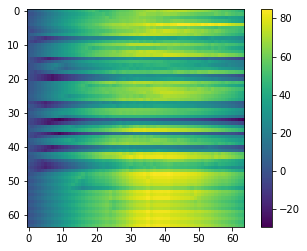

In [174]:
plt.imshow(np.unwrap(np.angle(f[7][(upsize_dim//2-32):(upsize_dim//2+32),(upsize_dim//2-32):(upsize_dim//2+32)])))
plt.colorbar()

Text(0, 0.5, '$w(z)$ m')

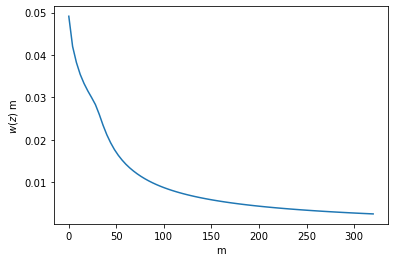

In [175]:
plt.plot(4*np.arange(len(w_lst)),w_lst)
plt.xlabel('m')
plt.ylabel('$w(z)$ m')

In [ ]:
1e-4*1e-3*1e10

In [ ]:
pfit, pcov, infodict, errmsg, success = leastsq(residual_wz, [0.027,-150,1e-4], args=(np.arange(len(w_lst)),w_lst),full_output=1)
plt.plot(4*np.arange(len(w_lst)),w_lst)
plt.plot(4*np.arange(len(w_lst)),wz_fit(np.arange(len(w_lst)),pfit[0],pfit[1],pfit[2]))
print('lambda=' + str(pfit[2]))

Text(0, 0.5, '$w$ m')

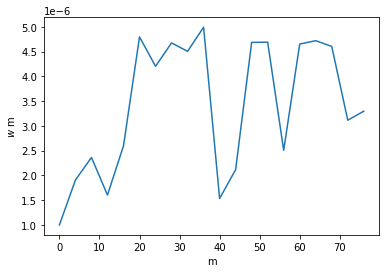

In [176]:
plt.plot(np.arange(len(params))*4,np.abs(params[:,3]))
plt.xlabel('m')
plt.ylabel('$w$ m')

In [ ]:
plt.plot(np.arange(len(params))*4,np.abs(params[:,0]))
plt.xlabel('m')
plt.ylabel('$A_d$ V/mm')

In [ ]:
plt.errorbar(.1*np.arange(len(params)),np.abs(params[:,0]),yerr=(res[:1994]*np.sqrt(hess_inv[:,0])),marker='.', alpha=0.6)
plt.xlabel('m')
plt.ylabel('$A_d m$')

In [ ]:
plt.plot(np.arange(len(err_lst)),err_lst)
plt.xlabel('m')
plt.ylabel('RMSE')

In [ ]:
np.argmax(params[:,0])

In [ ]:
plt.imshow(np.unwrap(np.angle(f[200])))
plt.colorbar()

In [ ]:
def prop_fit(f):
    # full output includes w and err to save time
    w_lst=[]
    err_lst =[]
    params = np.zeros((f.shape[0],3))
    hess_inv = np.zeros((f.shape[0],3))
    for i,field_slice in enumerate(f):
        #params[i] = curvature_radius_E(field_slice)[0]
        params[i], hess_inv[i], err, w_z = curvature_radius_E(field_slice)
        w_lst.append(w_z)
        err_lst.append(err)
    return params, hess_inv, err_lst, w_lst

In [ ]:
import time

In [ ]:
# Wave length in unit mm 
parax.numeric_parameters.wavelength = 1.3e-7
# Spacing between points on x and y axes
parax.numeric_parameters.dx=1000*window_extent/(grid_dim)
parax.numeric_parameters.dy=1000*window_extent/(grid_dim)

parax.numeric_parameters.dz=1000

# Number of points on the x and y axes
parax.numeric_parameters.N_x = upsize_dim
parax.numeric_parameters.N_y = upsize_dim
start = time.time()

params_lst = []
hess_inv_lst = []
err_lst_container = []
w_lst_container = []
propagation_container = []

for E_field in E_field_lst[9:12]:
    field_center = E_field.reshape((grid_dim,grid_dim))
    f0 = 1j*np.zeros((upsize_dim,upsize_dim))
    f0[(upsize_dim//2-32):(upsize_dim//2+32),(upsize_dim//2-32):(upsize_dim//2+32)] = field_center
    system = [100000]
    f = parax.experimental_simulator.experimental_simulator_2d.propagate(f0, system, output_full = True, forward = False, print_output=True)
    params, hess_inv, err_lst, w_lst = prop_fit(f)
    params_lst.append(params)
    hess_inv_lst.append(hess_inv)
    err_lst_container.append(err_lst)
    w_lst_container.append(w_lst)
    propagation_container.append(f)
    
end = time.time()
print((end - start)//60, ' min')

In [ ]:
params_lst[0].shape

In [ ]:
z0_lst = []

for i,params in enumerate(params_lst):
    len_nan = sum(np.isnan(params))[0]
    params = params[np.logical_not(np.isnan(params))].reshape((params.shape[0] - len_nan,3))
    z0 = np.argmax(params[:,0])
    z0_lst.append(z0)
    
res_lst = []

for hess_inv,err_lst in zip(hess_inv_lst,err_lst_container):
    res = [np.sqrt(hess_inv[i])*err_lst[i]**2 for i in range(len(err_lst)) if np.any(hess_inv[i] != np.nan)]
    res_lst.append(res)

for hess_inv,w_lst in zip(hess_inv_lst,w_lst_container):
    w_lst = [w_lst[i] for i,w_lst in enumerate(w_lst_container) if np.all(hess_inv[i] != np.nan)]

In [ ]:
plt.hist(z0_lst, bins=50)
plt.xlabel('$\Delta z$ m')

In [ ]:
plt.figure(figsize=(25,20))
for i in range(20):
    plt.subplot(4,5,i+1)
    rand_sample = int(np.random.uniform(0,len(params_lst)))
    plt.plot(.1*np.arange(len(params_lst[rand_sample])),np.abs(params_lst[rand_sample][:,2]))
    plt.ylabel('$R(z)$ m')
    plt.xlabel('m')
    plt.title('sample number ' + str(rand_sample))

In [ ]:
plt.figure(figsize=(30,24))
for i in range(20):
    plt.subplot(4,5,i+1)
    rand_sample = int(np.random.uniform(0,len(params_lst)))
    plt.plot(.1*np.arange(len(params_lst[rand_sample])),np.abs(params_lst[rand_sample][:,0]))
    plt.ylabel('$A$ m')
    plt.xlabel('m')
    plt.title('sample number ' + str(rand_sample))

Can check using R from direct fit and w container 

compare phase to initial plot at beam waist

numerical not meaningful if we extend beyond twice beam waist

In [ ]:
amplitudes_container = np.array(params_lst)[:,:,0]
phase_shift_container = np.array(params_lst)[:,:,1]
Rz_container = np.array(params_lst)[:,:,2]

In [ ]:
def Rz_fit(delta_z,w_0,z_0):
    z_R = pi*w_0**2/lambda_
    return (delta_z+z_0)*(1+(z_R/(delta_z+z_0))**2)

def residual_Rz(p,delta_z,R):
    w_0,z_0 = p
    R_hat = Rz_fit(delta_z,w_0,z_0)
    return R - R_hat

Rz_fit_container=[]
delta_z_container=[]
for Rz in Rz_container:
    delta_z = []
    R_clean = []
    for i,R_eval in enumerate(Rz):
        if not np.isnan(R_eval):
            delta_z.append(i)
            R_clean.append(R_eval)
    pfit, pcov, infodict, errmsg, success = leastsq(residual_Rz, np.array([0.01,1]), args=(delta_z,R_clean),full_output=1)
    Rz_fit_container.append(pfit)
    delta_z_container.append(delta_z)

In [ ]:
plt.plot(R_clean)
plt.plot(Rz_fit(delta_z,pfit[0],pfit[1]))

In [ ]:
plt.plot(R_clean)

In [ ]:
plt.figure(figsize=(20,20))
for i,z0 in enumerate(z0_lst[:16]):
    plt.subplot(4,4,i+1)
    plt.imshow(np.abs(propagation_container[i][-1]))
    #plt.imshow(np.unwrap(np.angle(propagation_container[i][-1][(upsize_dim//2-32):(upsize_dim//2+32),(upsize_dim//2-32):(upsize_dim//2+32)])))
    plt.colorbar()
    plt.title('z0=' + str(49))

In [ ]:
plt.figure(figsize=(20,20))
for i,z0 in enumerate(z0_lst[:16]):
    plt.subplot(4,4,i+1)
    plt.imshow(np.unwrap(np.angle(propagation_container[i][int(z0)][(upsize_dim//2-32):(upsize_dim//2+32),(upsize_dim//2-32):(upsize_dim//2+32)])))
    plt.colorbar()
    plt.title('z0=' + str(z0))

In [ ]:
def wz_fit(delta_z,w_0,z_0,wavelen):
    z_R = pi*w_0**2/wavelen
    return w_0*(1+((delta_z+z_0)/z_R)**2)**0.5

def residual_wz(p,delta_z,w):
    w_0,z_0, wavelen = p
    w_hat = wz_fit(delta_z,w_0,z_0,wavelen)
    return w - w_hat


wz_fit_container=[]
for w_lst in w_lst_container:
    delta_z = np.arange(7)
    #pfit, pcov = sp.optimize.curve_fit(wz_fit,delta_z,w_lst[:32],p0=[0.027,-15,9.16e-5])
    pfit, pcov, infodict, errmsg, success = leastsq(residual_wz, [0.01,-4,1e-4], args=(delta_z,w_lst[:7]),full_output=1)
    wz_fit_container.append(pfit)

In [ ]:
plt.plot(w_lst_container[0][:7])
plt.plot(wz_fit(delta_z,wz_fit_container[0][0],wz_fit_container[0][1],wz_fit_container[0][2]))
#plt.plot(wz_fit(delta_z,.027,-4,9.1609e-5))

In [ ]:
plt.figure(figsize=(20,20))
for i,w_lst in enumerate(w_lst_container):
    plt.subplot(4,4,i+1)
    plt.plot(w_lst[:7])
    plt.plot(wz_fit(delta_z,wz_fit_container[i][0],wz_fit_container[i][1],wz_fit_container[i][2]))
    plt.title('lambda=' + str(wz_fit_container[i][2]))